# Lesson: Building a Visual Browser Tool

Welcome to this lesson on building a powerful, multimodal AI agent. So far, we've seen how tools can return text. But what if a tool could return an *image*?

In this notebook, we will build a **Visual Browser Tool**. Instead of just scraping text from a website, our tool will:
1.  Use the **Selenium** library to control a real, headless web browser.
2.  Navigate to a URL and take a **screenshot** of the rendered page.
3.  Pass that **image** back to the Gemini model.

This allows the AI to "see" the webpage just like a human, analyzing its layout, images, and visual hierarchy to answer questions. This is a powerful, multimodal approach to building capable agents.

In [ ]:
#@title 1. Setup
# Install the Google AI Python SDK
!pip install -q -U google-generativeai markdownify

In [ ]:
#@title 2. Configure your API Key
# Use the "Secrets" tab in Colab (click the key icon on the left) to store your
# API key with the name "GOOGLE_API_KEY".
from google import genai
from google.colab import userdata

try:
    GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
    client = genai.Client(api_key=GOOGLE_API_KEY)
except userdata.SecretNotFoundError as e:
    print('Secret not found. Please add your GOOGLE_API_KEY to the Colab Secrets Manager.')

In [ ]:
!apt install -y chromium-browser

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor libfuse3-3 libudev1 snapd squashfs-tools systemd-hwe-hwdb udev
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser libfuse3-3 snapd squashfs-tools systemd-hwe-hwdb
  udev
The following packages will be upgraded:
  libudev1
1 upgraded, 7 newly installed, 0 to remove and 37 not upgraded.
Need to get 34.1 MB of archives.
After this operation, 134 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.4 [598 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 squashfs-tools amd64 1:4.5-3build1 [159 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libudev1 amd64 249.11-0ubuntu3.17 [76.7 kB]
Get:4 http://archive.ubuntu.com/

In [ ]:
%pip install -q selenium webdriver-manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 35.8 MB/s eta 0:00:00


### 1. Define the Visual Browser Tool

First, we'll create our core tool: a Python function named `browse_url`. This function uses the `selenium` library to launch a headless (invisible) Chromium browser, navigate to a given URL, wait for it to load, and save a screenshot as `screenshot.png`.

In [ ]:
import time
import markdownify
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

SCREENSHOT_FILE = 'screenshot.png'


def browse_url(url: str) -> str:
    """Captures a screenshot of the webpage at the provided URL.

    A graphical browser will be used to connect to the URL provided,
    and generate a screenshot of the rendered web page.

    Args:
        url: The full absolute URL to browse/screenshot.

    Returns:
        "ok" if successfully captured, or any error messages.
    """
    try:
      chrome_options = webdriver.ChromeOptions()
      chrome_options.add_argument('--headless')
      chrome_options.add_argument('--no-sandbox')
      chrome_options.headless = True
      driver = webdriver.Chrome(options=chrome_options)

      # Take one large image, 2x high as it is wide. This should be enough to
      # capture most of a page's interesting info, and should capture anything
      # designed "above the fold", without going too deep into things like
      # footer links, infinitely scrolling pages, etc.
      # Otherwise multiple images are needed, which requires waiting, scrolling
      # and stitching, and introduces lag that slows down interactions.
      driver.set_window_size(1024, 2048)
      driver.get(url)

      # Wait for the page to fully load.
      time.sleep(5)
      driver.save_screenshot(SCREENSHOT_FILE)

      print(f"Screenshot saved to {SCREENSHOT_FILE}")
      #print(markdownify.markdownify(driver.page_source))
      return markdownify.markdownify(driver.page_source)

    except Exception as e:
      print(f"An error occurred: {e}")
      return str(e)

    finally:
      # Close the browser
      if driver:
        driver.quit()

Screenshot saved to screenshot.png


### 2. Test the Tool and View the Screenshot

We've just called our `browse_url` function with a Wikipedia URL to make sure it works. It should have created a file named `screenshot.png`. Let's display that image to see what our headless browser captured.

In [ ]:
url = "https://en.wikipedia.org/wiki/Castle"
browse_url(url);

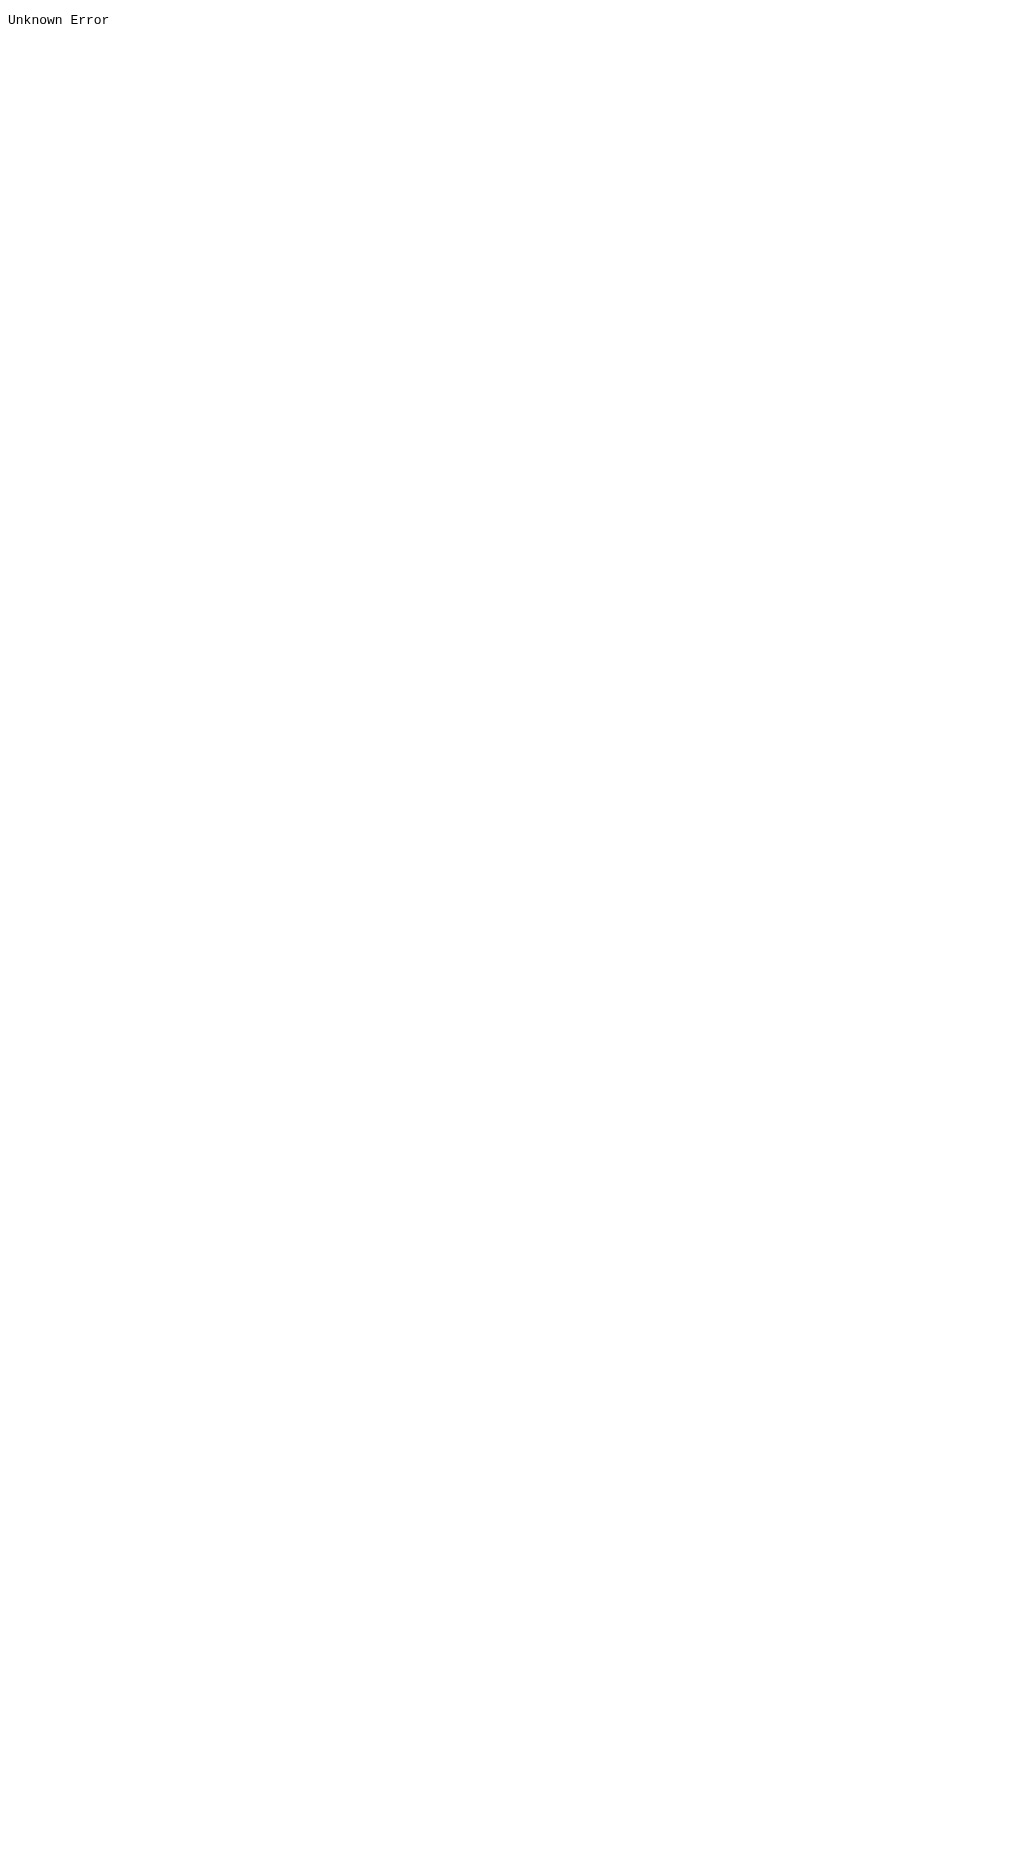

In [ ]:
from IPython.display import Image, Markdown

Image('screenshot.png')

### 3. Connect the Browser Tool to the Model

Now, we'll connect our new tool to the Gemini model.

* **System Instruction:** We provide a clear `sys_int` (system instruction) that tells the model its role. It should act as a web browser, use the `browse_url` tool, and analyze the resulting screenshot to answer questions.
* **Disabling Automatic Function Calling:** This is a crucial step. Because our tool's true "output" is an image (which can't be returned in a standard function response), we must set `automatic_function_calling` to `False`. This tells the model to wait for us to manually handle the tool execution.

In [ ]:
sys_int = """You are a system with access to websites via the `browse_url` tool.
Use the `browse_url` tool to browse a URL and generate a screenshot that will be
returned for you to see and inspect, like using a web browser.

When a user requests information, first use your knowledge to determine a specific
page URL, tell the user the URL and then invoke the `browse_url` tool with this URL. The
tool will supply a screenshot of the website, at which point you will examine the contents of the
screenshot to answer the user's questions. Do not ask the user to proceed, just act.

You will not be able to inspect the page HTML, so determine the most specific page
URL, rather than starting navigation from a site's homepage.
"""

chat = client.chats.create(
    model="gemini-2.5-flash",
    config={'tools': [browse_url], 'system_instruction': sys_int, "automatic_function_calling": {"disable": True}})

response = chat.send_message('Search google for latest news on GST')
parts = response.candidates[0].content.parts
for part in parts:
  if text:=part.text:
    print(text)
  elif fc:=part.function_call:
    print(fc.args["url"])

I will browse the following URL for the latest news on GST: https://economictimes.indiatimes.com/topic/gst-news
https://economictimes.indiatimes.com/topic/gst-news


### 4. The Model Decides to Use the Tool

As you can see from the output, the model has analyzed our prompt ("Search google for latest news on GST") and correctly decided that it needs to call the `browse_url` tool. It has also formulated the correct URL to visit to perform the search. Our next step is to manually execute this request.

In this step, we took the `function_call` from the model's response and ran our `browse_url` function with the URL it provided.

We then constructed a multi-part `response_parts` list to send back to the model. This is the key to the visual interaction:
1.  A standard `FunctionResponse` to confirm the tool ran.
2.  The actual screenshot image (`img`) as a separate part.

Let's look at the screenshot that we are about to send back to the model.

In [45]:
import PIL

response_parts = []

# For each function call, generate the response in two parts. Once for the
# function response, and one for the image as regular content. This simulates
# the function "returning" an image to the model as part of a function call.
for part in parts:
  if fn := part.function_call:
    assert fn.name == 'browse_url'

    url = fn.args['url']
    print(url)
    response = browse_url(url)
    #print(response)

    img = PIL.Image.open(SCREENSHOT_FILE)

    fr = genai.types.Part(function_response=genai.types.FunctionResponse(
        name=fn.name,
        id=fn.id,
        response={'result': response},
    ))
    response_parts.extend([fr, img])

https://economictimes.indiatimes.com/topic/gst-news
Screenshot saved to screenshot.png


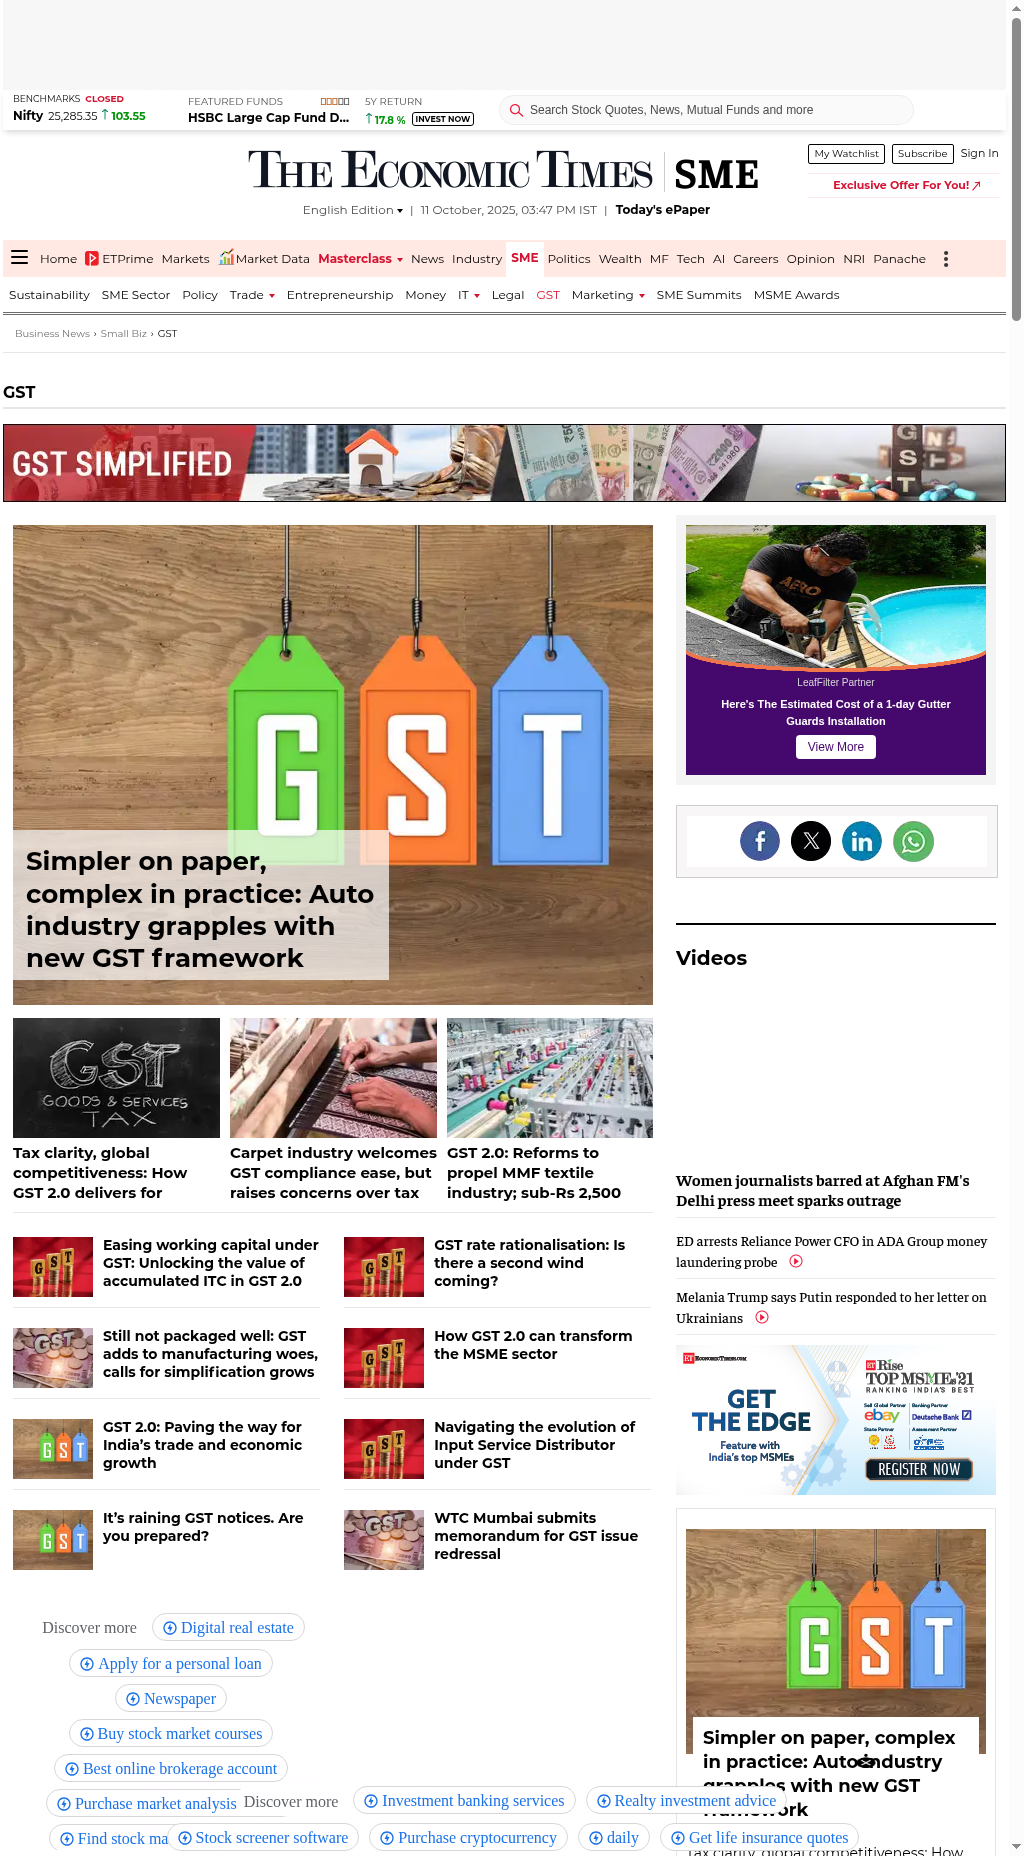

In [ ]:
Image(SCREENSHOT_FILE)

### 5. The Model Analyzes the Screenshot

We have now sent the screenshot of the Google search results back to the model. For its final turn, the model will "look" at this image, read the headlines and summaries, and use that visual information to formulate its final, natural language answer.

In [46]:
from IPython.display import Markdown

response2 = chat.send_message(response_parts)
Markdown(response2.text)


Here is the latest news on GST from The Economic Times as of October 11, 2025:

*   **"Simpler on paper, complex in practice: Auto industry grapples with new GST framework"**: This article discusses how GST rate rationalisation can impact the automotive sector.
*   **"Tax clarity, global competitiveness: How GST 2.0 delivers for exporters"**: This article highlights how GST 2.0 reforms can benefit exporters.
*   **"Carpet industry welcomes GST compliance ease, but raises concerns over tax on finished products"**: This piece covers the carpet industry's perspective on GST.
*   **"GST 2.0: Reforms to propel MMF textile industry; sub-Rs 2,500 retail segment poised for growth"**: This article focuses on the impact of GST 2.0 on the Man-Made Fibre (MMF) textile industry.
*   **"Easing working capital under GST: Unlocking the value of accumulated ITC in GST 2.0"**: This article delves into how working capital can be eased under GST.
*   **"GST rate rationalisation: Is there a second wind coming?"**: This article explores the possibility of further GST rate rationalization.
*   **"Still not packaged well: GST adds to manufacturing woes, calls for simplification grows"**: This piece discusses the challenges faced by the manufacturing sector due to GST.
*   **"How GST 2.0 can transform the MSME sector"**: This article explains the potential of GST 2.0 to transform the Micro, Small, and Medium Enterprises (MSME) sector.
*   **"GST 2.0: Paving the way for India’s trade and economic growth"**: This article talks about how GST 2.0 can contribute to India's economic growth.
*   **"Navigating the evolution of Input Service Distributor under GST"**: This article provides insights into the evolution of the Input Service Distributor under GST.
*   **"It’s raining GST notices. Are you prepared?"**: This article provides guidance on preparing for GST notices.
*   **"WTC Mumbai submits memorandum for GST issue redressal"**: This piece reports on WTC Mumbai's efforts to address GST-related issues.